## Computer Vision techniques to identify lanes and track them in real time videos as well as images 

We will use a combination of computer vision concepts and image processing tools to try and track lanes on a variety of roads

In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

# the test images we'll apply our CV tool to
test_img_dir = "test_images/"
original_image_names = os.listdir(test_img_dir)
original_image_names = list(map(lambda name: test_img_dir + name, original_image_names))
print(original_image_names)

['test_images/solidWhiteCurve.jpg', 'test_images/solidWhiteRight.jpg', 'test_images/solidYellowCurve.jpg', 'test_images/solidYellowLeft.jpg', 'test_images/video_challenge_0s.jpg', 'test_images/video_challenge_1s.jpg', 'test_images/video_challenge_2s.jpg', 'test_images/video_challenge_4s.jpg', 'test_images/video_challenge_5s.jpg', 'test_images/video_challenge_6s.jpg', 'test_images/video_yellow_lane_left_12s.jpg', 'test_images/video_yellow_lane_left_13s.jpg', 'test_images/video_yellow_lane_left_3s.jpg', 'test_images/whiteCarLaneSwitch.jpg']


In [3]:
def show_image_list(image_list, cols =2, fig_size = (15,15), labels = original_image_names, show_ticks = True):
    img_count = len(image_list)
    rows = img_count / cols
    cmap = None
    plt.figure(figsize=fig_size)
    for i in range(0, img_count):
        img_name = labels[i]
        
        plt.subplot(rows, cols, i+1)
        img = image_list[i]
        if (len(img.shape) < 3):
            cmap = "gray"
        if not show_ticks:
            plt.xticks([])
            plt.yticks([])
        
        plt.title(img_name[len(test_img_dir):])
        plt.imshow(img, cmap = cmap)
    plt.tight_layout()
    plt.show()

In [5]:
print( "The shape of one image is:", original_images[0].shape)

The shape of one image is: (540, 960, 3)


# How exactly can we detect the lane lines in the images above?

1. Convert image to Hue, Saturation, Lightness channels (HSL)
2. Distinguish yellow and white from the HSL images
3. Use grayscale images for easier manipulation
4. Apply Gaussian Blur to smoothen edges
5. Use canny edge detection
6. Find a region of interest, discard all other lines outside this region
7. Perform a Hough transform to find lanes within the region, trace in a color
8. Separate left and right lanes, extrapolate to create two smooth lines

## HSL refers to Hue, Saturation and Lightness (amount of white), whereas HSB is concerned with brightness (amount of light of any colour)

### We can write some functions to convert RGB to these representations which may be handy in identifying lanes

In [6]:
def to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
def to_hsl(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

In [7]:
hsv_images = list(map(lambda img: to_hsv(img), original_images))
hsl_images = list(map(lambda img: to_hsl(img), original_images))

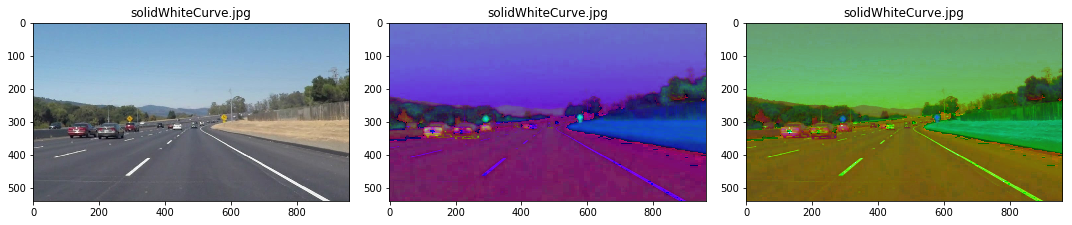

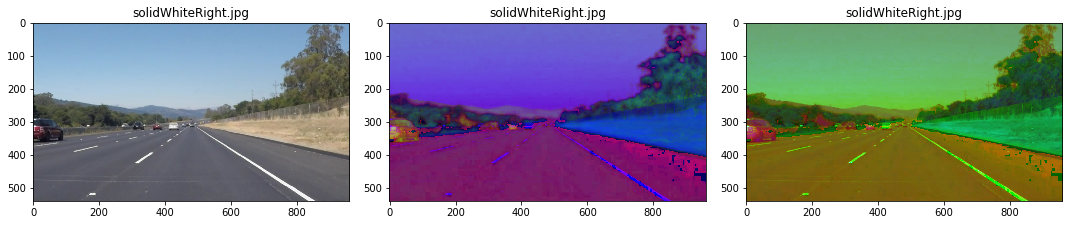

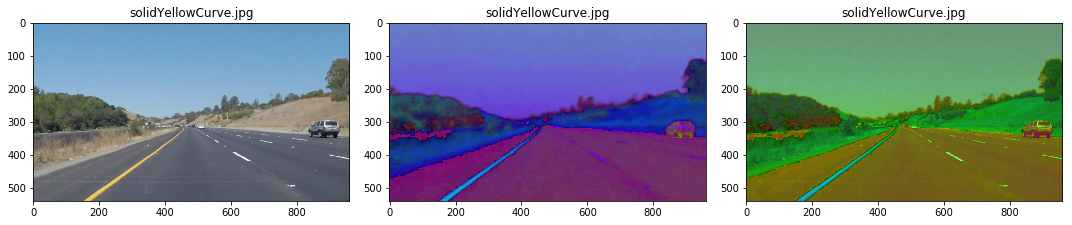

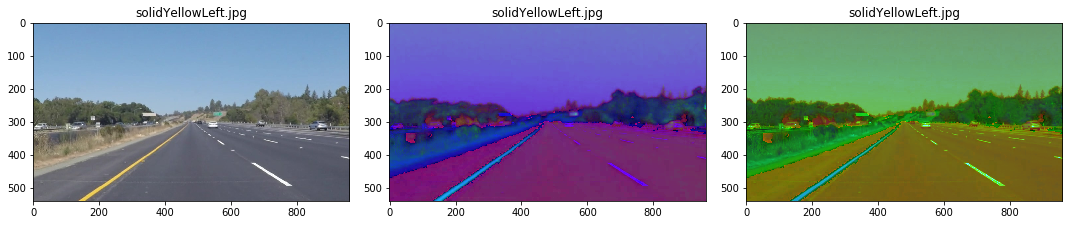

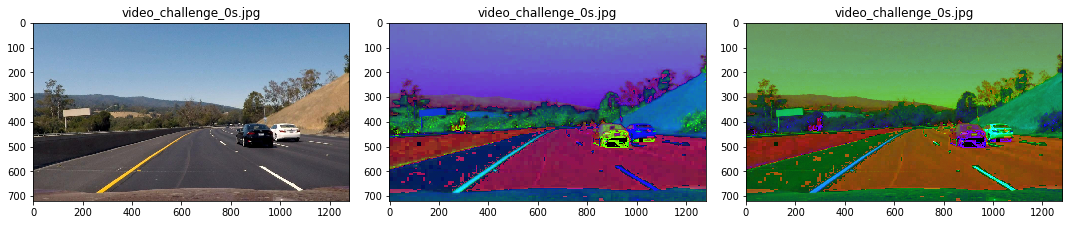

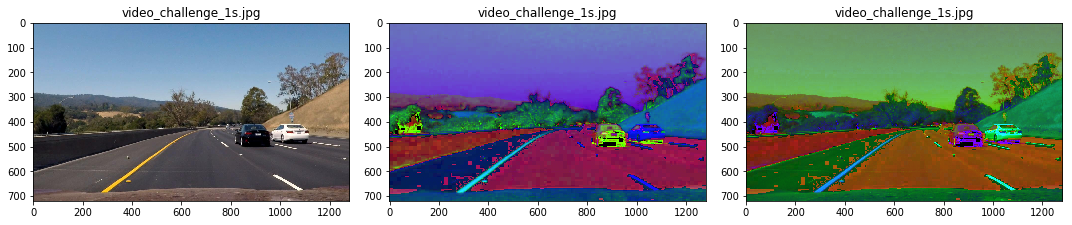

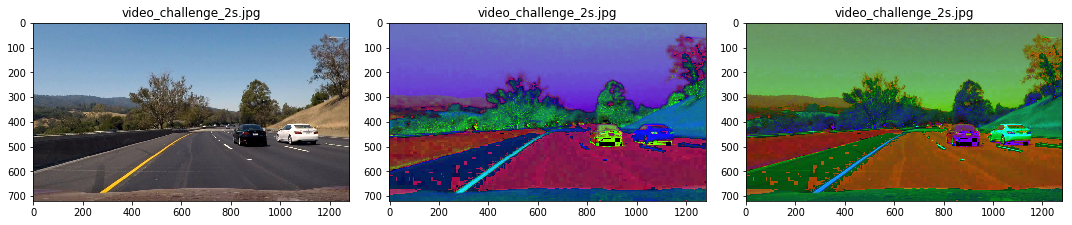

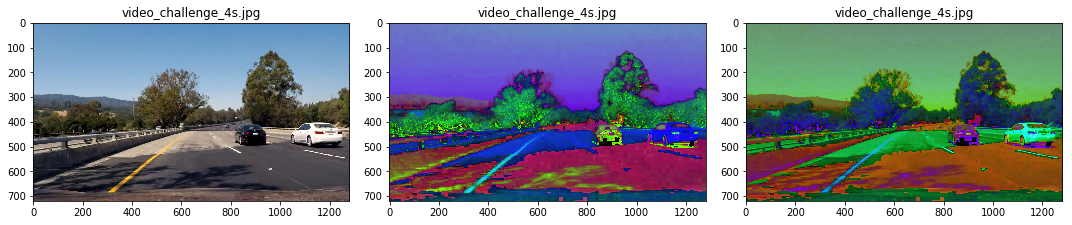

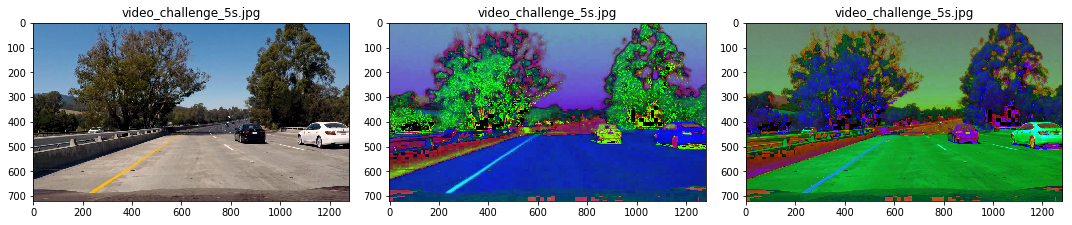

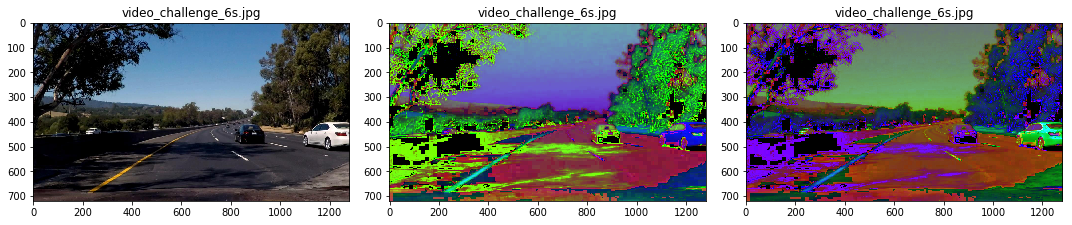

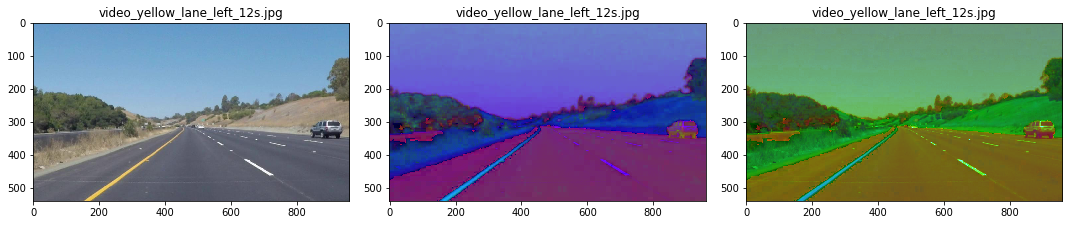

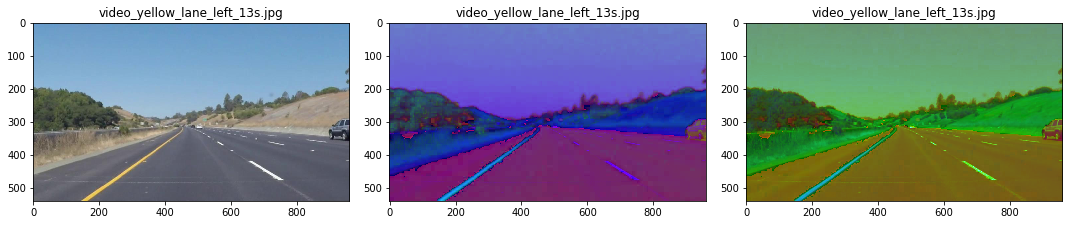

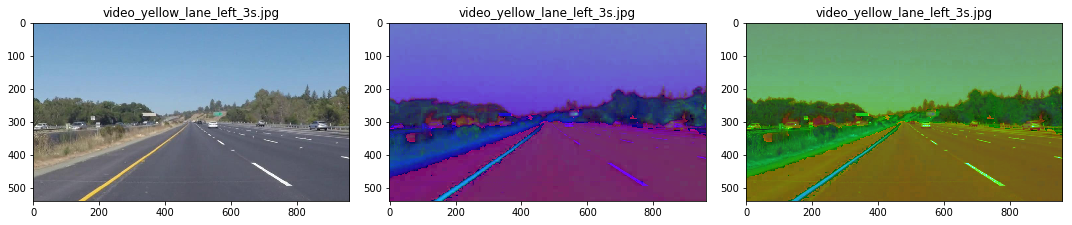

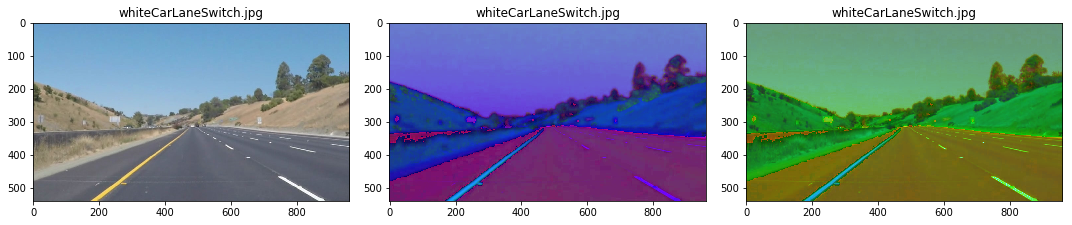

In [8]:
count = len(hsv_images)
zipped = list(zip(original_images, hsv_images, hsl_images))

k = 0
for image in zipped:
    name = original_image_names[k]
    show_image_list(image, cols = 3, fig_size=(15,15), labels = [name, name, name])
    k = k+1

## Clearly HSL is better at contrasting the brighter lane lines than HSV (which seems to blur the white lines out)
### we will proceed with HSL analysis

### We can try and isolate the yellow and white from the originals. HSL transformations maps components as follows:

* H is between 0 and 180 
* S and L are between 0 and 255

In [9]:
## Assuming the image is already in HSL format...

def isolate_yellow_hsl(img):
    ## open cv does this in HLS format, yellow has a fair amount of "white" so L will have a range of values to search from
    low_threshold = np.array([15,38, 115], dtype = np.uint8)
    high_threshold = np.array([35, 225, 255], dtype = np.uint8)
    
    mask = cv2.inRange(img, low_threshold, high_threshold)
    return mask

In [10]:
def isolate_white_hsl(img):
    ## white will need a high lightness boundary 
    low_threshold = np.array([0, 200, 0], dtype=np.uint8)
    high_threshold = np.array([180, 255, 255], dtype=np.uint8)  
    
    white_mask = cv2.inRange(img, low_threshold, high_threshold)
    
    return white_mask

In [11]:
hsi_yellow_images = list(map(lambda img: isolate_yellow_hsl(img), hsl_images))
hsi_white_images = list(map(lambda img: isolate_white_hsl(img), hsl_images))

In [13]:
## These masks can be combined using an OR operation, and then combined with the original image with an AND operation to keep what is common between the two

In [14]:
def combine_hsl_with_original(img, hsl_yellow, hsl_white):
    hsl_mask = cv2.bitwise_or(hsl_yellow, hsl_white)
    return cv2.bitwise_and(img, img, mask = hsl_mask)

def filter_img_hsl(img):
    hsl_img = to_hsl(img)
    hsl_yellow = isolate_yellow_hsl(hsl_img)
    hsl_white = isolate_white_hsl(hsl_img)
    return combine_hsl_with_original(img, hsl_yellow, hsl_white)

In [15]:
combined_hsl_images = hsl_images = list(map(lambda img: filter_img_hsl(img), original_images))

## Convert to Grayscale

The contrast will be high if the image is in grayscale (for the white/yellow lines), since the road is black and the other elements are much brighter

In [17]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

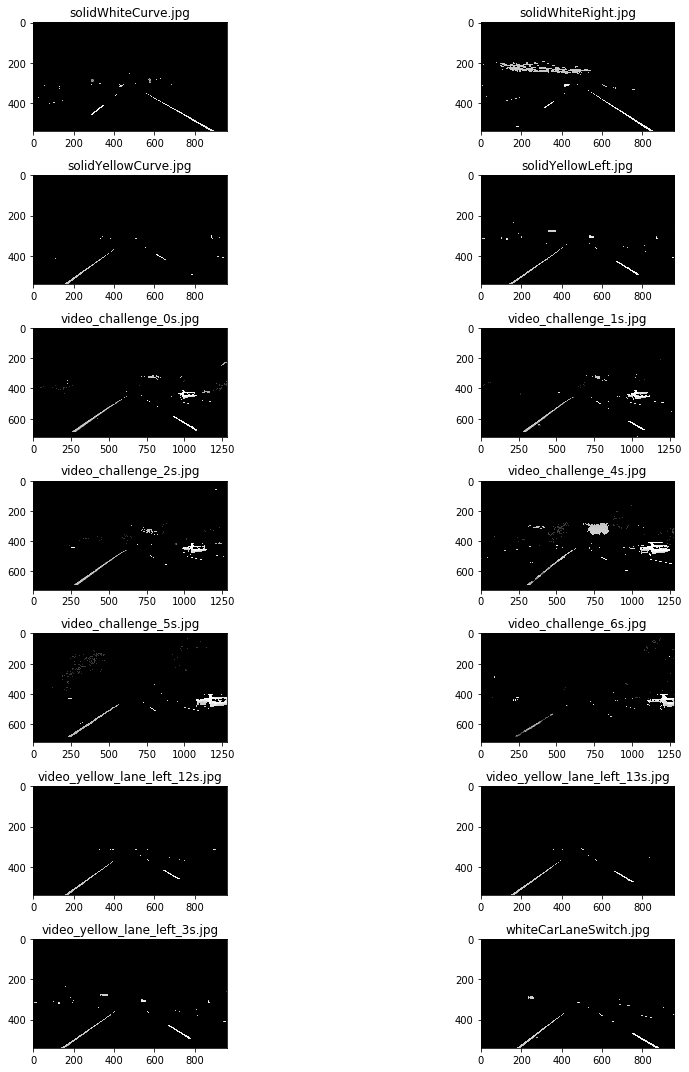

In [18]:
grayscale_images = list(map(lambda img: grayscale(img), combined_hsl_images))
show_image_list(grayscale_images)

# Gaussian Blur 

This can help smoothen edges of an image to reduce noise. 

In [19]:
def gaussian_blur(gray_img, kernel_size = 3):
    return cv2.GaussianBlur(gray_img, (kernel_size, kernel_size), 0)

In [20]:
# Let's apply a few diffeerent blurring kernels (must be an odd number)

blurred_images1 = list(map(lambda img: gaussian_blur(img, kernel_size=5), grayscale_images))
blurred_images2 = list(map(lambda img: gaussian_blur(img, kernel_size=11), grayscale_images))
blurred_images3 = list(map(lambda img: gaussian_blur(img, kernel_size=21), grayscale_images))

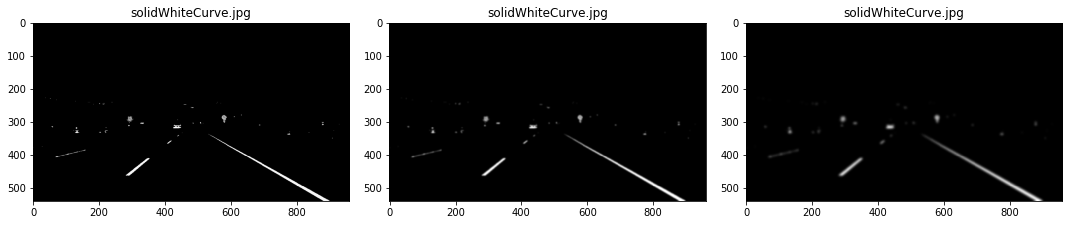

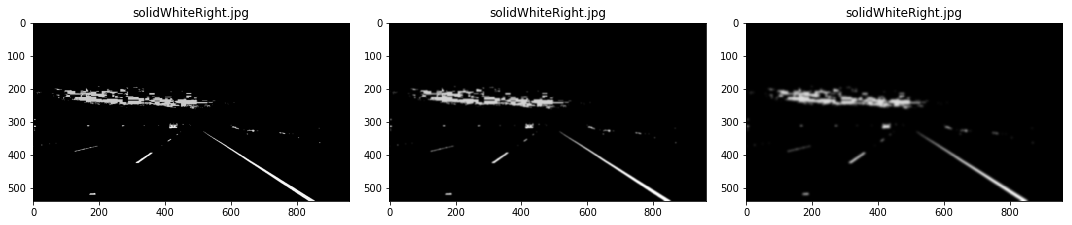

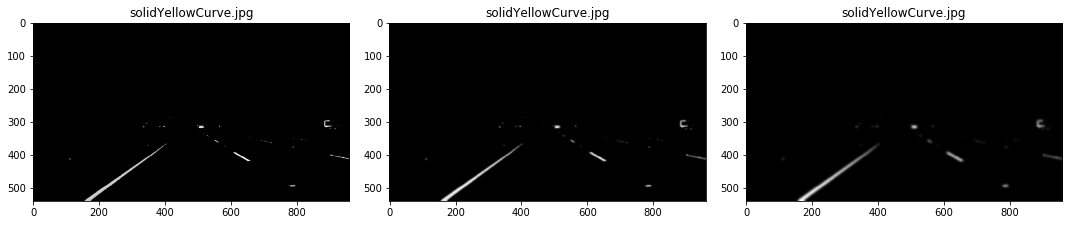

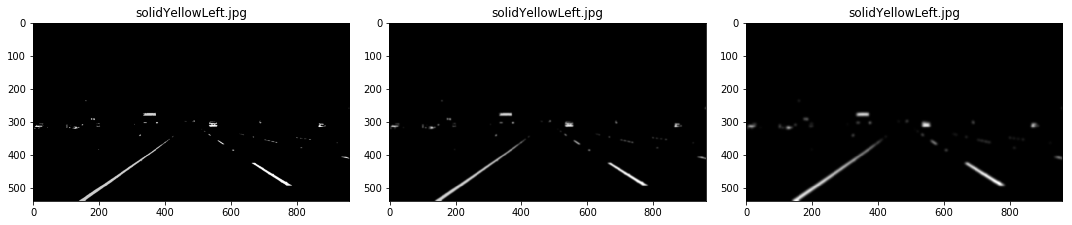

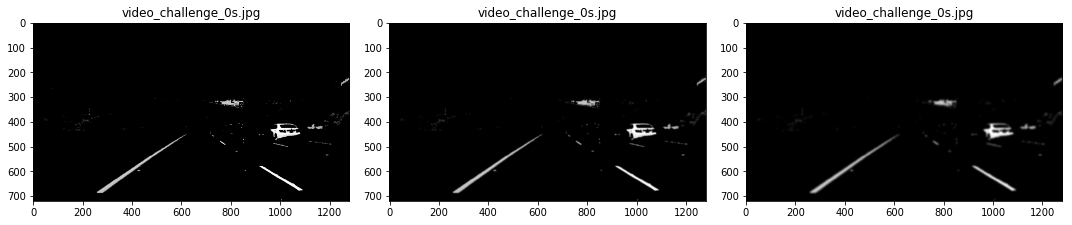

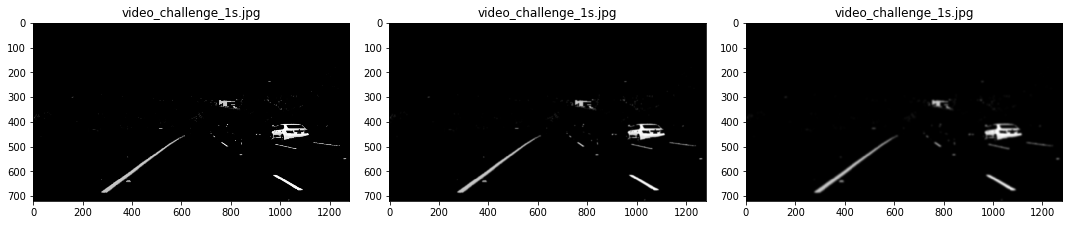

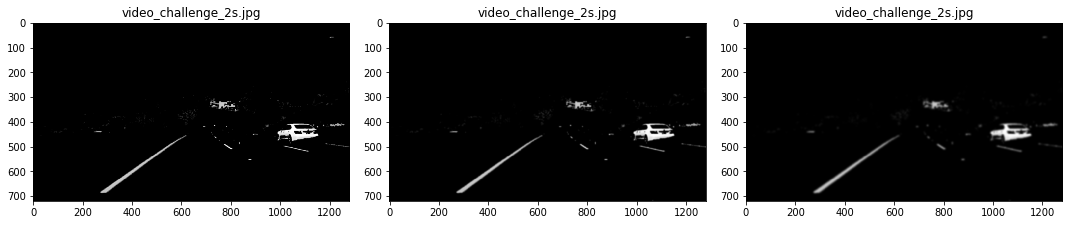

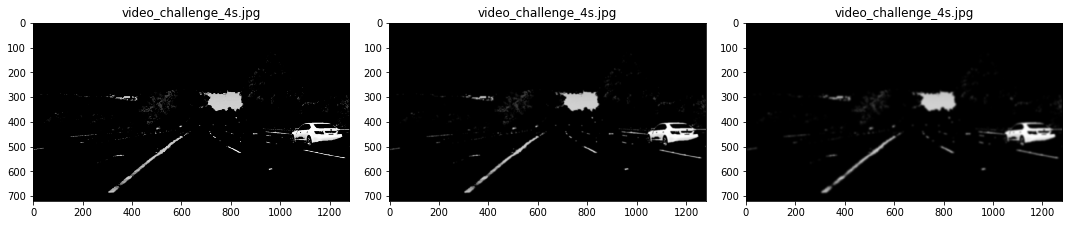

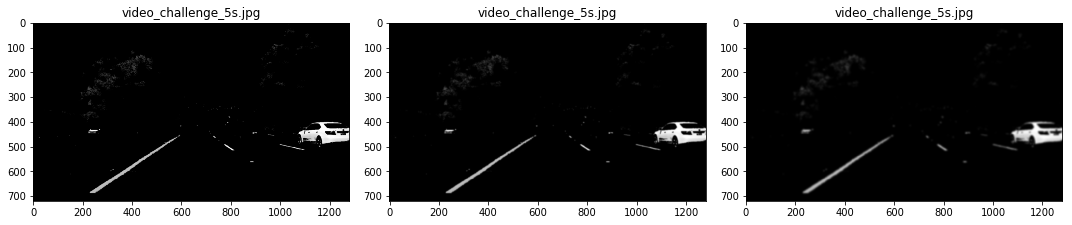

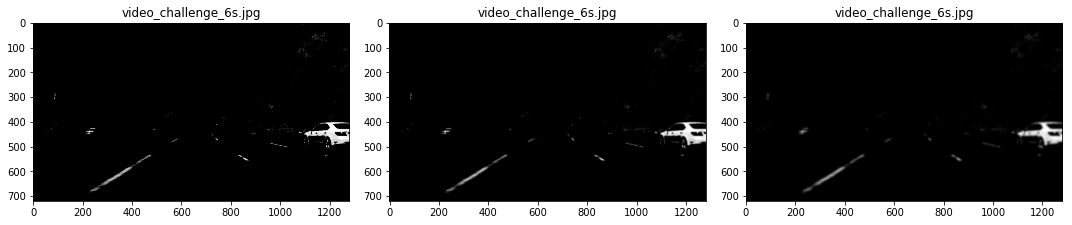

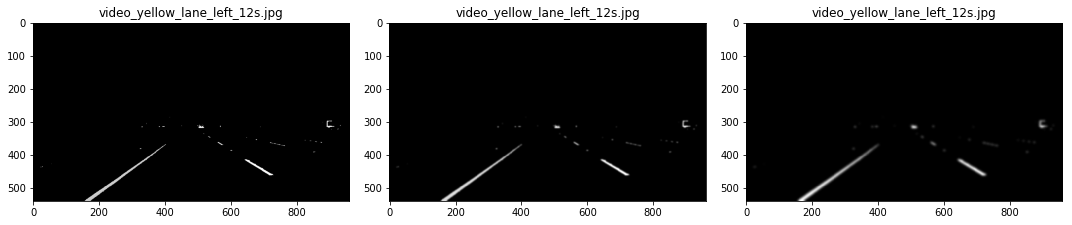

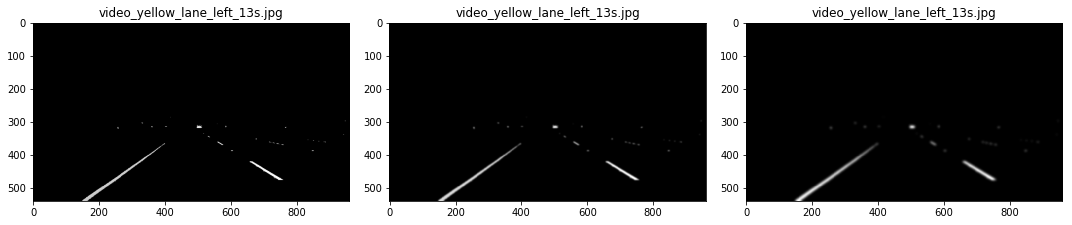

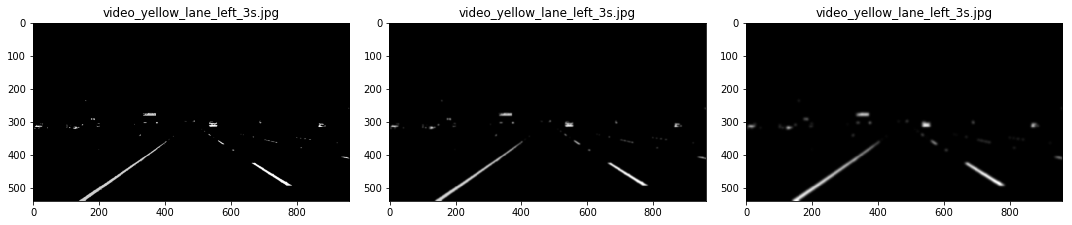

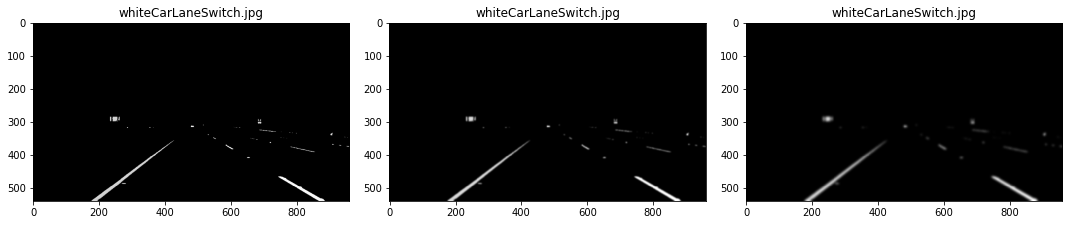

In [21]:

img_count = len(blurred_images1)
interleaved_blur = list(zip(blurred_images1, blurred_images2, blurred_images3))

k = 0
for blurs in interleaved_blur:
    img_name = original_image_names[k]
    show_image_list(blurs, cols=3, fig_size=(15, 15), labels=[img_name, img_name, img_name] )
    k += 1

# Canny Edge Detection

We will use the kernel size of 5 for the blur.

A canny edge detector identifies lines in an image and discards other data by analyzing pixel gradients. 

We will need to pass in a low and high threshold. Any point beyond the high threshold will be included in our resulting image; points between the values will only be included if they are next to edges beyond our high threshold. Recommended ratios are 1:3 or 1:2 for low:high

In [22]:
def canny_edge_detector(blurredimg, low_thres, high_thres):
    return cv2.Canny(blurredimg, low_thres, high_thres)

In [23]:
canny_images1 = list(map(lambda img: canny_edge_detector(img, 50, 150), blurred_images1)) 
canny_images2 = list(map(lambda img: canny_edge_detector(img, 0, 10), blurred_images1)) 
canny_images3 = list(map(lambda img: canny_edge_detector(img, 10, 50), blurred_images1))


## Region of Interest

Find ROI, discard areas outside the region. We can "guess" what the region may be by following the contours of the lanes and defining a shape which will act as our region of interest below

In [25]:
def get_vertices_for_img(img):
    imshape = img.shape
    height = imshape[0]
    width = imshape[1]

    vert = None
    
    if (width, height) == (960, 540):
        region_bottom_left = (130 ,imshape[0] - 1)
        region_top_left = (410, 330)
        region_top_right = (650, 350)
        region_bottom_right = (imshape[1] - 30,imshape[0] - 1)
        vert = np.array([[region_bottom_left , region_top_left, region_top_right, region_bottom_right]], dtype=np.int32)
    else:
        region_bottom_left = (200 , 680)
        region_top_left = (600, 450)
        region_top_right = (750, 450)
        region_bottom_right = (1100, 650)
        vert = np.array([[region_bottom_left , region_top_left, region_top_right, region_bottom_right]], dtype=np.int32)

    return vert

def region_of_interest(img):
    mask = np.zeros_like(img)   
        
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    vert = get_vertices_for_img(img)    
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vert, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [26]:
segmented_images = list(map(lambda img: region_of_interest(img), canny_images1))
canny_segmented_images = list(zip(canny_images1, segmented_images))

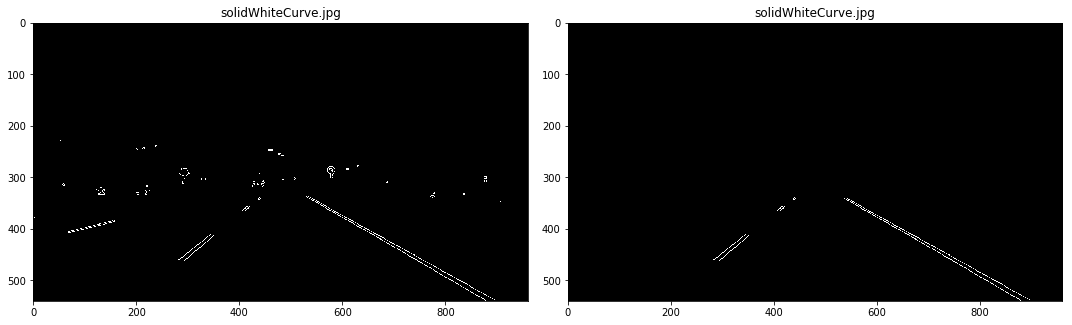

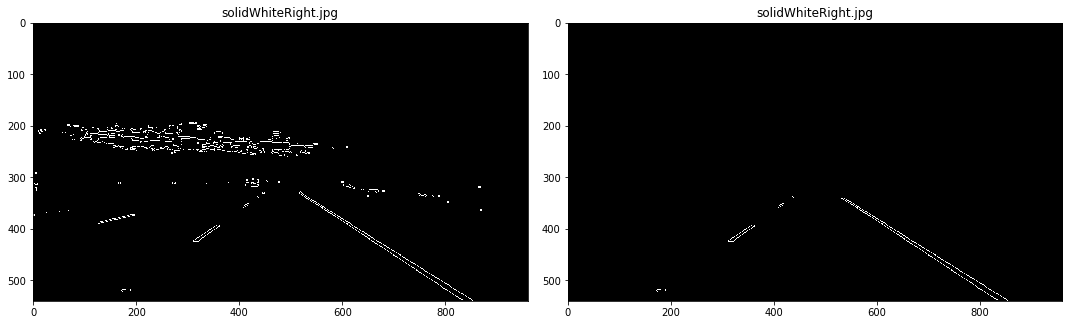

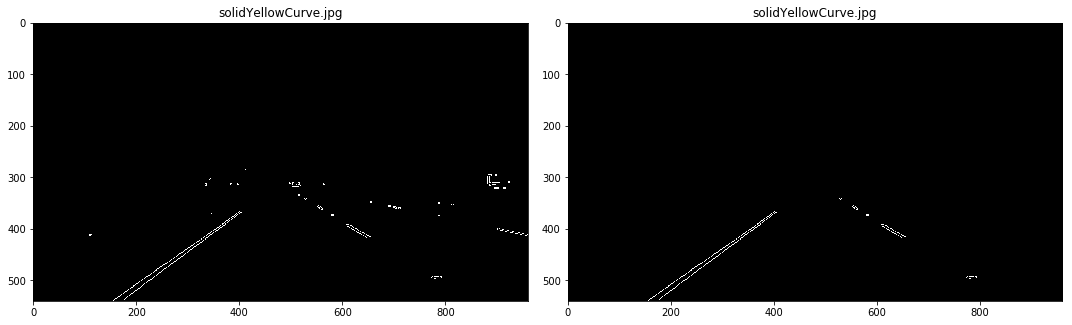

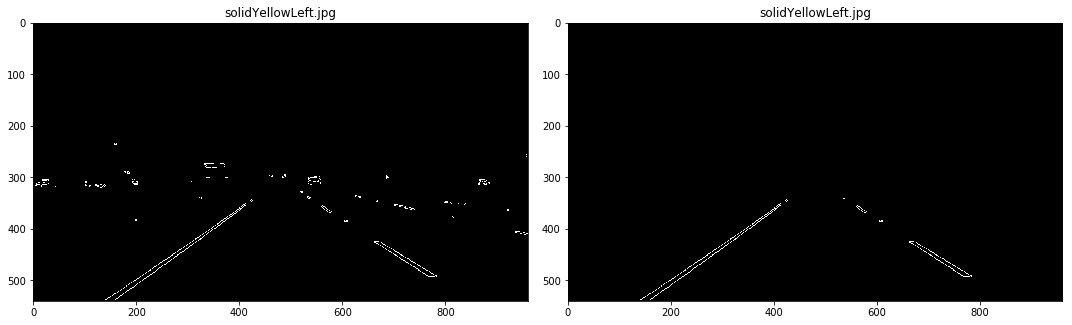

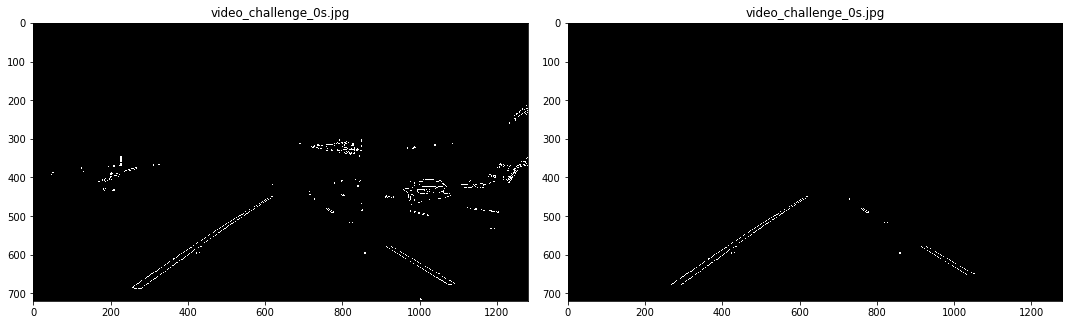

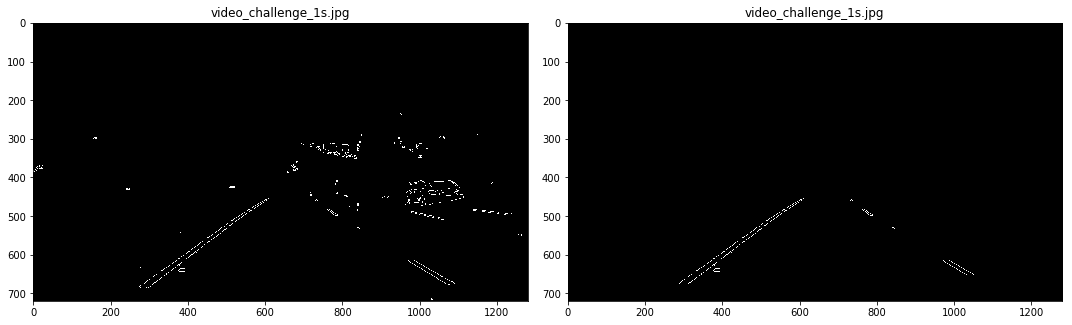

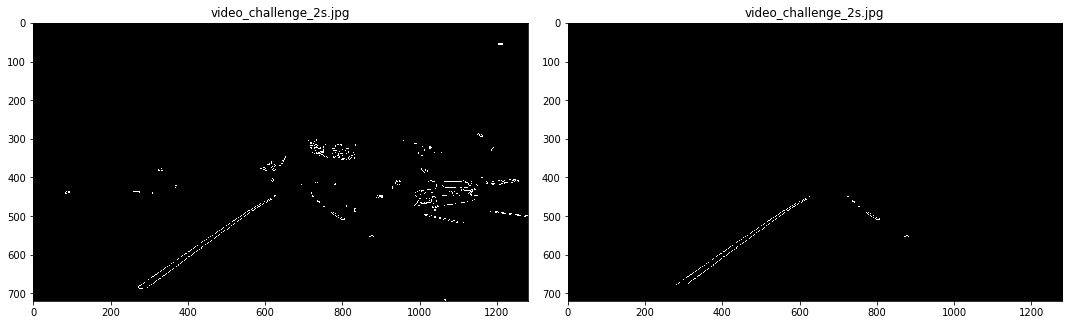

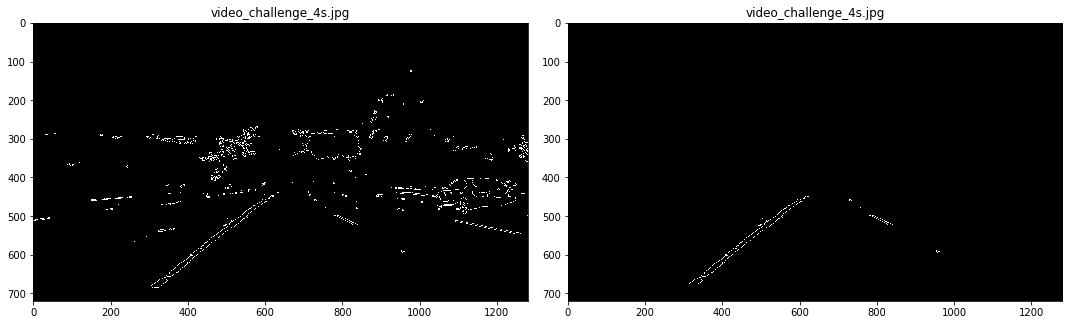

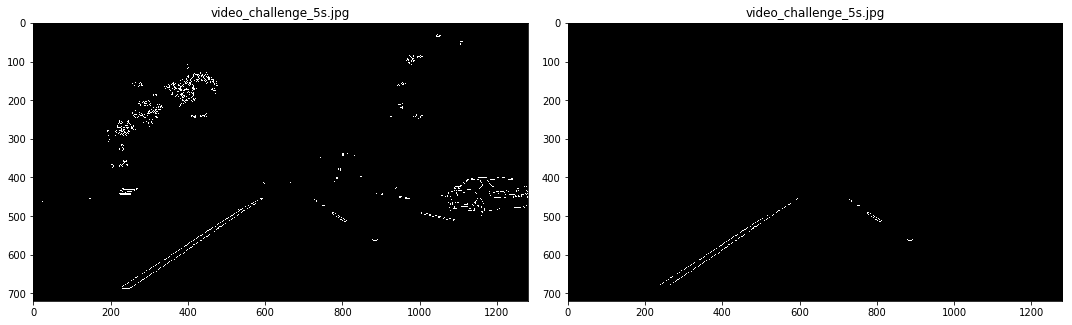

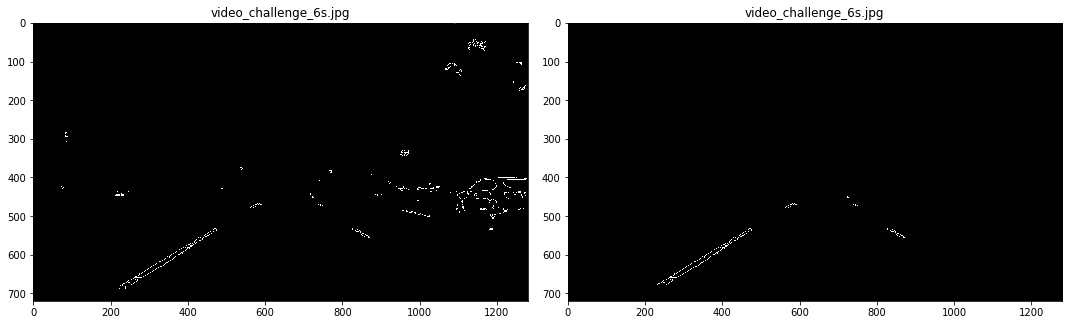

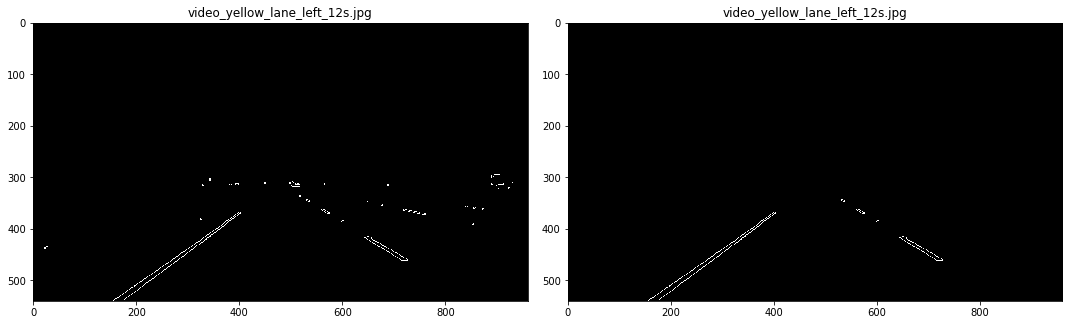

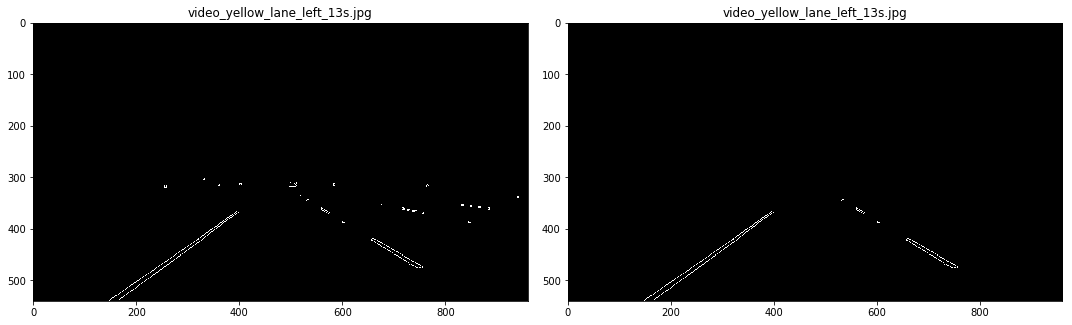

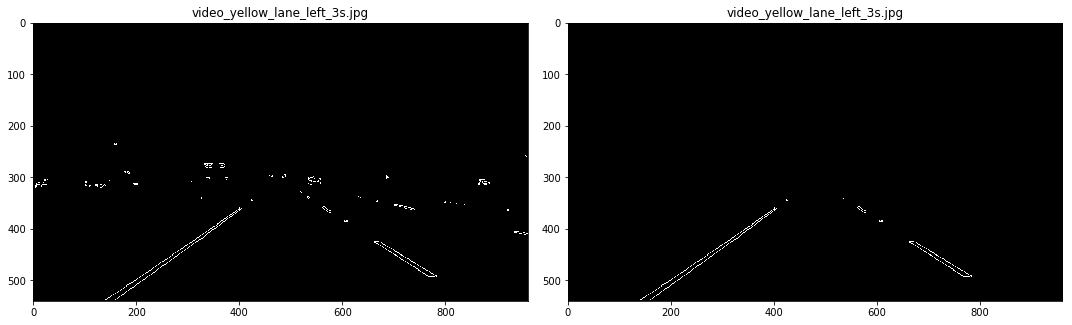

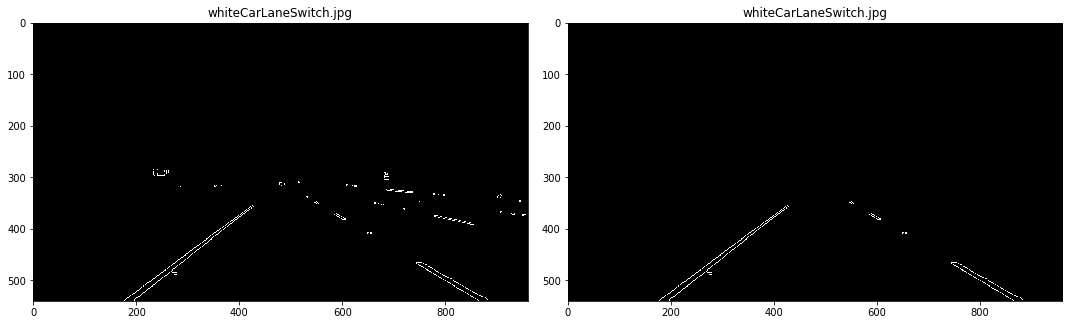

In [27]:

k = 0
for canny_segmented_img in canny_segmented_images: 
    img_name = original_image_names[k]
    show_image_list(canny_segmented_img, labels=[img_name, img_name])
    k += 1

## Hough Transform

This finds lines by identifying all the points that lie on them. -> Convert the x,y coordinate system to a parametric system

--> lines become points
--> points becomes lines
--> intersecting lines mean the same point is on multiple lines

 A given line will now be expressed as (ρ, θ):  ρ = x cos θ + y sin θ.
 
 This puts the image into Hough space.


In [28]:
def hough_transform(canny_img, rho, theta, threshold, min_lin_len, max_line_gap):
    return cv2.HoughLinesP(canny_img, rho, theta, threshold, np.array([]), minLineLength = min_lin_len, maxLineGap = max_line_gap)

In [29]:
rho = 1
# 1 degree accuracy
theta = (np.pi/180) * 1
threshold = 15
min_line_length = 20
max_line_gap = 10

In [30]:
hough_lines_per_image = list(map(lambda img: hough_transform(img, rho, theta, threshold, min_line_length, max_line_gap), segmented_images ))

## Drawing lines to visualize the hough transform output

In [31]:
def draw_lines(img, lines, color = [150,0,150], thickness = 10, make_copy = True):
    img_copy = np.copy(img) if make_copy else img
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img_copy, (x1, y1), (x2, y2), color, thickness)
    return img_copy

## Separating Left and Right lanes

* Left Lane gradient: slope is negative

* Right Lane gradient: slope is positive


In [33]:
def separate_lines(lines, img):
    img_shape = img.shape
    
    middle_x = img_shape[1]/2
    
    left_lane_lines = []
    right_lane_lines = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            dx = x2 - x1
            if (dx ==0):
                continue
            dy = y2 -y1
            
            if (dy ==0):
                continue
                
            slope = dy/dx
            
            if slope < 0 and x1 < middle_x and x2 < middle_x:
                left_lane_lines.append([[x1, y1, x2, y2]])
            elif x1 >= middle_x and x2 >= middle_x:
                right_lane_lines.append([[x1, y1, x2, y2]])
    
    return left_lane_lines, right_lane_lines

In [34]:
separated_lanes_per_image = list(map(lambda lines, img: separate_lines(lines, img), hough_lines_per_image, original_images))

In [104]:
def color_lanes(img, left_lane_lines, right_lane_lines, left_lane_color=[25, 200, 30], right_lane_color=[200, 0, 20]):
    left_colored_img = draw_lines(img, left_lane_lines, color=left_lane_color, make_copy=True)
    right_colored_img = draw_lines(left_colored_img, right_lane_lines, color=right_lane_color, make_copy=False)
    
    return right_colored_img

In [105]:
img_different_lane_colors = list(map(lambda img, separated_lanes: color_lanes(img, separated_lanes[0], separated_lanes[1]), original_images, separated_lanes_per_image))

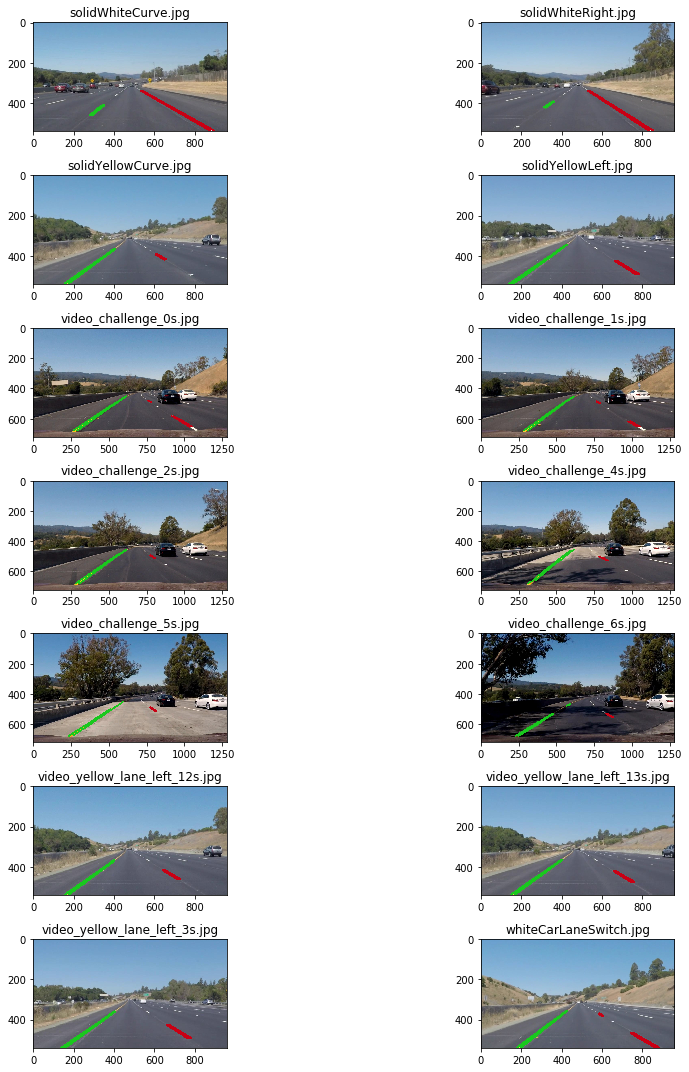

In [106]:
show_image_list(img_different_lane_colors)

## Lane extrapolation

Essentially, we need to trace the lines from bottom to top entirely.

A simple linear regression, minimising the least squares error between the interpolated points 

In [107]:
from scipy import stats

def find_lane_lines_formula(lines):
    xs = []
    ys = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            xs.append(x1)
            xs.append(x2)
            ys.append(y1)
            ys.append(y2)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(xs, ys)
    
    return (slope, intercept)

In [122]:

def trace_lane_line(img, lines, top_y, make_copy=True):
    A, b = find_lane_lines_formula(lines)
    vert = get_vertices_for_img(img)

    img_shape = img.shape
    bottom_y = img_shape[0] - 1
    # x = (y - b) / A
    x_to_bottom_y = (bottom_y - b) / A
    
    top_x_to_y = (top_y - b) / A 
    
    new_lines = [[[int(x_to_bottom_y), int(bottom_y), int(top_x_to_y), int(top_y)]]]
    return draw_lines(img, new_lines, make_copy=make_copy)

def trace_both_lane_lines(img, left_lane_lines, right_lane_lines):
    vert = get_vertices_for_img(img)
    region_top_left = vert[0][1]
    
    full_left_lane_img = trace_lane_line(img, left_lane_lines, region_top_left[1], make_copy=True)
    full_left_right_lanes_img = trace_lane_line(full_left_lane_img, right_lane_lines, region_top_left[1], make_copy=False)
    
    img_with_lane_weight =  cv2.addWeighted(img, 0.6, full_left_right_lanes_img, 0.5, 0.0)
    
    return img_with_lane_weight

In [123]:
full_lane_drawn_images = list(map(lambda img, separated_lanes : trace_both_lane_lines(img, separated_lanes[0], separated_lanes[1]), 
                                  original_images, separated_lanes_per_image))

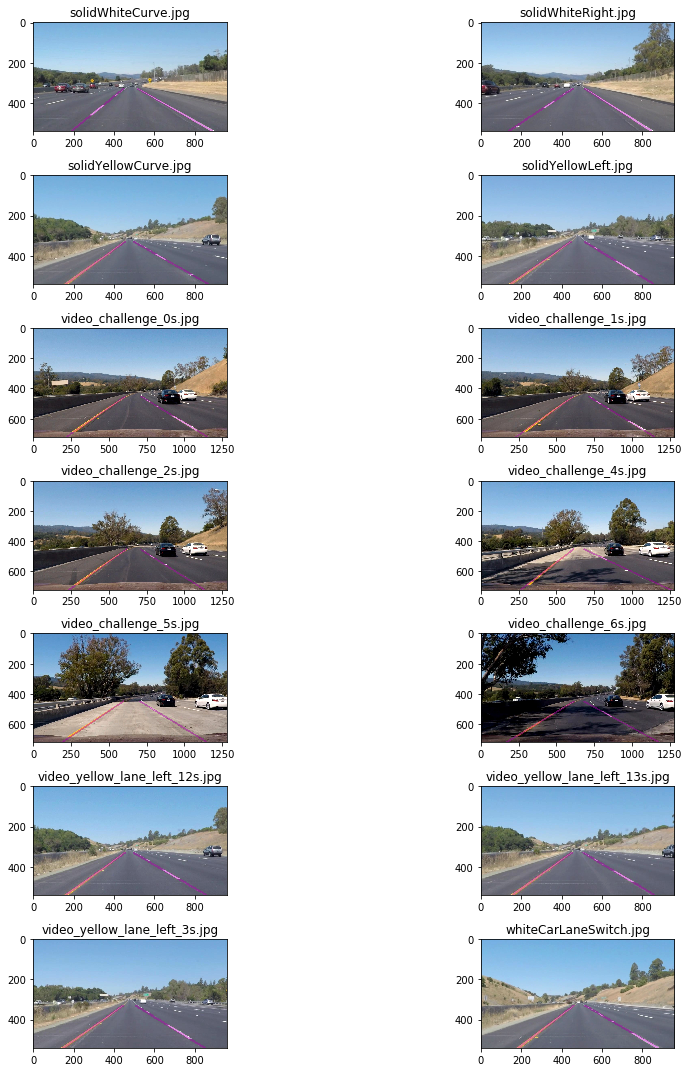

In [124]:
show_image_list(full_lane_drawn_images)


## Lane Detection on videos

We can use the frame structure of videos to smoothen lines that we trace

-> If at frame t, the computed lines are very different from the mean of the line slopes from frames [0, t-1] 

-> In effect this is a kind of memory, we can use the deque in Python to store a bunch of line coefficients

-> We can also calculate weighted averages of these coefficients (more weight to recent coefficients since they belong to more recent frames)

In [114]:
from collections import deque

def create_lane_line_coefficients_list(length = 10):
    return deque(maxlen=length)

In [115]:
def trace_lane_line_coefficients(img, line_coefficients, top_y, make_copy = True):
    A = line_coefficients[0]
    b = line_coefficients[1]
    
    img_shape = img.shape
    bottom_y = img_shape[0] - 1
    try:
        x_to_bottom_y = (bottom_y - b)/A
        top_x_to_y = (top_y - b)/A
        
    except:
        x_to_bottom_y = (bottom_y - b)
        top_x_to_y = (top_y - b)
        
    new_lines = [[[int(x_to_bottom_y), int(bottom_y), int(top_x_to_y), int(top_y)]]]
    return draw_lines(img, new_lines, make_copy=make_copy)


def trace_both_lane_lines_with_lines_coefficients(img, left_line_coefficients, right_line_coefficients):
    vert = get_vertices_for_img(img)
    region_top_left = vert[0][1]
    full_left_lane_img = trace_lane_line_coefficients(img, left_line_coefficients, region_top_left[1], make_copy=True)
    full_left_right_lanes_img = trace_lane_line_coefficients(full_left_lane_img, right_line_coefficients, region_top_left[1], make_copy=False)
    
    img_with_lane_weight =  cv2.addWeighted(img, 0.7, full_left_right_lanes_img, 0.3, 0.0)
    
    return img_with_lane_weight

In [116]:
import math

max_slope_diff = 0.1
max_intercept_diff = 50.0

class LaneDetectorWithMemory:
    def __init__(self):
        self.left_lane_coefficients  = create_lane_line_coefficients_list()
        self.right_lane_coefficients = create_lane_line_coefficients_list()
        
        self.previous_left_lane_coefficients = None
        self.previous_right_lane_coefficients = None  
    
    def mean_coefficients(self, coefficients_queue, axis = 0):
        return [0,0] if len(coefficients_queue) == 0 else np.mean(coefficients_queue, axis = axis)
    
    def determine_line_coefficients(self, stored_coefficients, current_coefficients):
        if len(stored_coefficients) == 0:
            stored_coefficients.append(current_coefficients)
            return current_coefficients
        
        mean = self.mean_coefficients(stored_coefficients)
        abs_slope_diff = abs(current_coefficients[0] - mean[0])
        abs_intercept_diff = abs(current_coefficients[1] - mean[1])
        
        if abs_slope_diff > max_slope_diff or abs_intercept_diff > max_intercept_diff:
            return mean
        
        else:
            # save our coefficients and returned a smoothened one
            stored_coefficients.append(current_coefficients)
            return self.mean_coefficients(stored_coefficients)
        
        
    def lane_detection_pipeline(self, img):
        combined_hsl_img = filter_img_hsl(img)
        grayscale_img = grayscale(combined_hsl_img)
        gaussian_smoothed_img = gaussian_blur(grayscale_img, kernel_size=5)
        canny_img = canny_edge_detector(gaussian_smoothed_img, 50, 150)
        segmented_img = region_of_interest(canny_img)
        hough_lines = hough_transform(segmented_img, rho, theta, threshold, min_line_length, max_line_gap)
        
        try:
            left_lane_lines, right_lane_lines = separate_lines(hough_lines, img)
            left_lane_slope, left_intercept = find_lane_lines_formula(left_lane_lines)
            right_lane_slope, right_intercept = find_lane_lines_formula(right_lane_lines)
            smoothed_left_lane_coefficients = self.determine_line_coefficients(self.left_lane_coefficients, [left_lane_slope, left_intercept])
            smoothed_right_lane_coefficients = self.determine_line_coefficients(self.right_lane_coefficients, [right_lane_slope, right_intercept])
            img_with_lane_lines = trace_both_lane_lines_with_lines_coefficients(img, smoothed_left_lane_coefficients, smoothed_right_lane_coefficients)
        
            return img_with_lane_lines
        
        except Exception as e:
            print("Will use saved coefficients ", e)
            smoothed_left_lane_coefficients = self.determine_line_coefficients(self.left_lane_coefficients, [0.0, 0.0])
            smoothed_right_lane_coefficients = self.determine_line_coefficients(self.right_lane_coefficients, [0.0, 0.0])
            img_with_lane_lines = trace_both_lane_lines_with_lines_coefficients(img, smoothed_left_lane_coefficients, smoothed_right_lane_coefficients)
        
            return img_with_lane_lines

## Testing it out on videos

In [117]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
white_vid = 'test_videos_output/solidWhiteRight.mp4'
detector = LaneDetectorWithMemory()

clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(detector.lane_detection_pipeline)
white_clip.write_videofile(white_vid, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_vid))

## Yellow lanes in video

In [ ]:
yellow_vid = 'test_videos_output/solid_Yellow_Left.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')

detector = LaneDetectorWithMemory()
yellow_clip = clip2.fl_image(detector.lane_detection_pipeline)
yellow_clip.write_videofile(yellow_vid, audio=True)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_vid))

## Challenge video

In [81]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')

#clip3.save_frame("test_images/video_challenge_0s.jpg", t=0) # saves the frame
#clip3.save_frame("test_images/video_challenge_4s.jpg", t=4) # saves the frame

detector = LaneDetectorWithMemory()
challenge_clip = clip3.fl_image(detector.lane_detection_pipeline)
challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



 58%|██████████████████████████████████████████████▏                                 | 145/251 [00:08<00:07, 14.21it/s]

Will use saved coefficients  Inputs must not be empty.



100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:16<00:00, 15.62it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 



In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))